In [1]:
import numpy as np
import matplotlib

In [5]:
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': True,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

C:\Users\RBO\AppData\Local\Temp\ipykernel_17076\1385736914.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mpl.cm.get_cmap('jet')


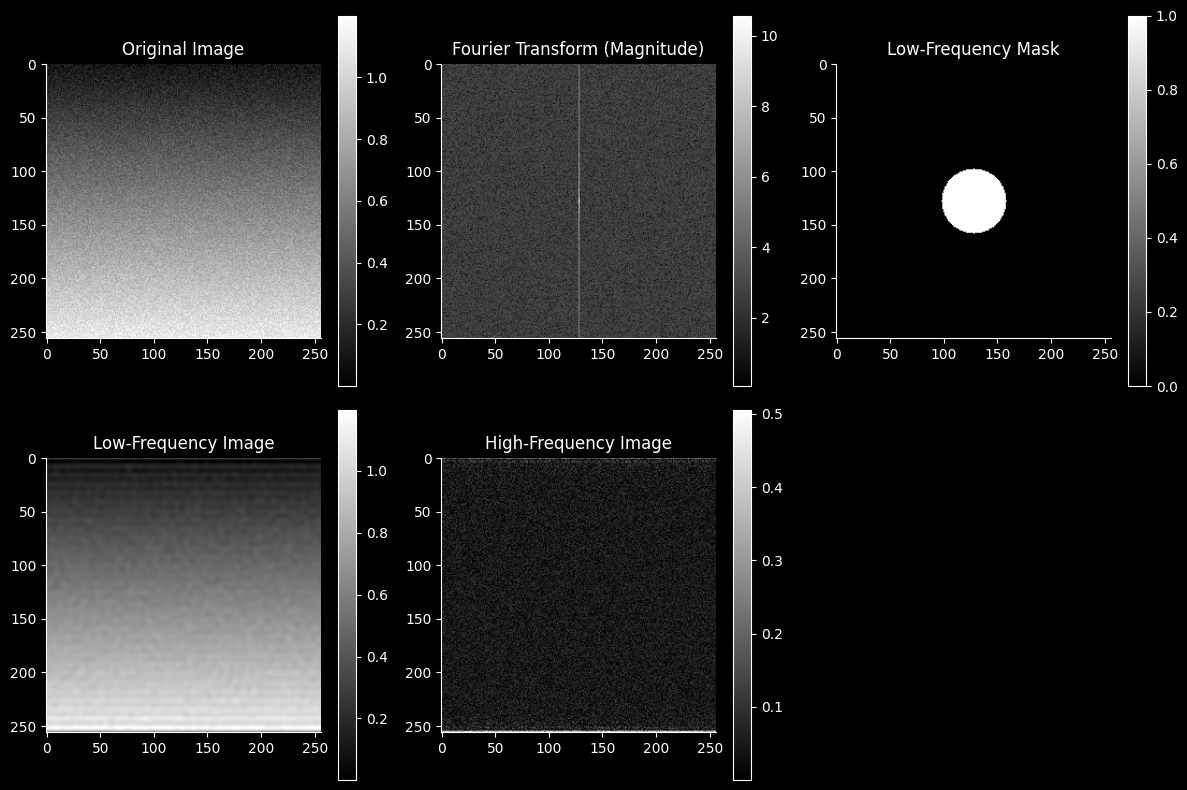

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift, ifft2

# Generate a sample image: smooth gradient + high-frequency noise
np.random.seed(42)
gradient = np.linspace(0, 1, 256).reshape(-1, 1)
noise = np.random.rand(256, 256) * 0.2
image = gradient + noise

# Compute the 2D Fourier Transform and shift zero frequency to the center
ft_image = fft2(image)
ft_image_shifted = fftshift(ft_image)

# Create a circular low-pass filter
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
radius = 30  # Radius for low frequencies
mask = np.zeros_like(image, dtype=bool)
y, x = np.ogrid[:rows, :cols]
mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius ** 2
mask[mask_area] = True

# Low-frequency and high-frequency components
low_freq = ft_image_shifted * mask
high_freq = ft_image_shifted * ~mask

# Inverse Fourier Transform to reconstruct images
low_freq_image = np.abs(ifft2(np.fft.ifftshift(low_freq)))
high_freq_image = np.abs(ifft2(np.fft.ifftshift(high_freq)))

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.title("Fourier Transform (Magnitude)")
plt.imshow(np.log(1 + np.abs(ft_image_shifted)), cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.title("Low-Frequency Mask")
plt.imshow(mask, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Low-Frequency Image")
plt.imshow(low_freq_image, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("High-Frequency Image")
plt.imshow(high_freq_image, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


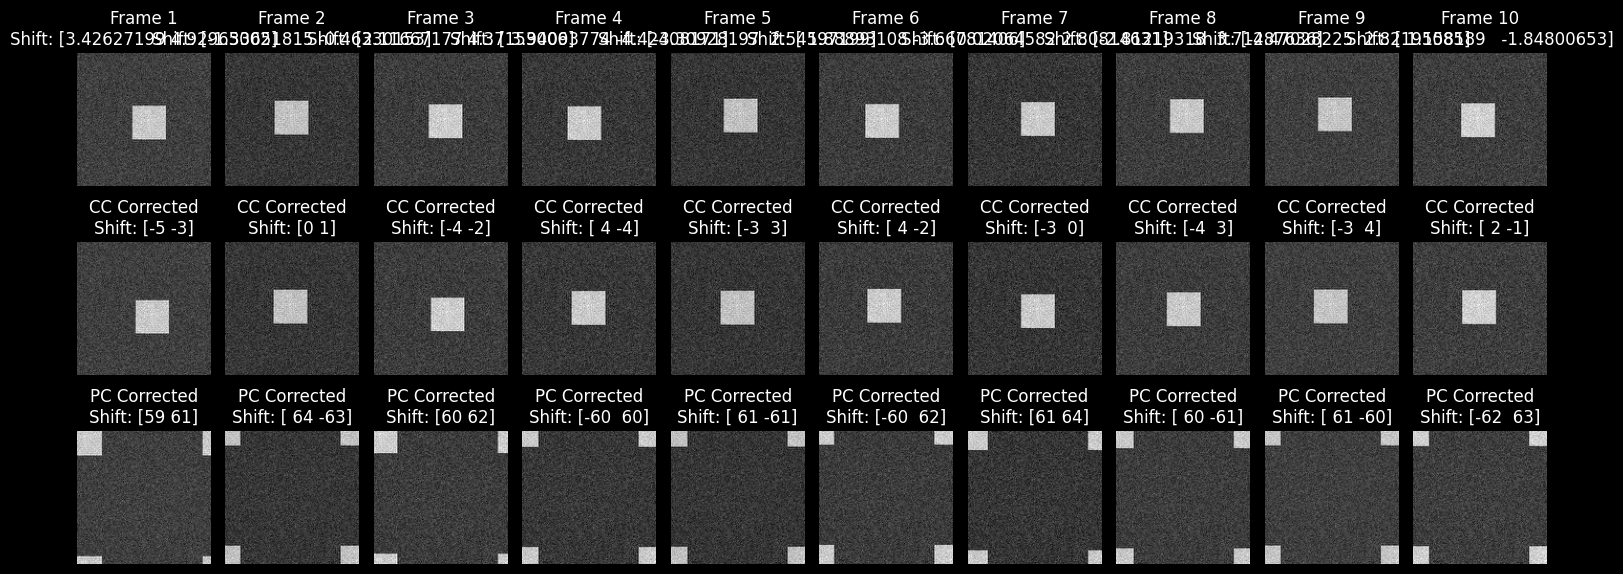

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import fourier_shift
from scipy.fft import fft2, ifft2, fftshift, ifftshift

np.random.seed(42)
image_size = (128, 128)
reference_image = np.zeros(image_size)
reference_image[48:80, 48:80] = 1  # Simulate a soma
reference_image += np.random.normal(0, 0.1, image_size)  # Add noise

n_frames = 10
shifts = np.random.uniform(-5, 5, (n_frames, 2))  # Random shifts (y, x)
frames = [np.real(ifft2(fourier_shift(fft2(reference_image), shift))) for shift in shifts]

def cross_correlation_register(frame, target):
    corr = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(frame) * np.conj(np.fft.fft2(target))))
    max_idx = np.unravel_index(np.argmax(np.abs(corr)), corr.shape)
    shift = np.array(max_idx) - np.array(corr.shape) // 2
    return -shift[::-1]  # Return shift as (x, y)

def phase_correlation_register(frame, target):
    # Spatial whitening: divide by magnitude spectrum
    frame_ft = fft2(frame)
    target_ft = fft2(target)
    frame_whitened = frame_ft / (np.abs(frame_ft) + 1e-8)
    target_whitened = target_ft / (np.abs(target_ft) + 1e-8)
    phase_corr = ifft2(frame_whitened * np.conj(target_whitened))
    max_idx = np.unravel_index(np.argmax(np.abs(phase_corr)), phase_corr.shape)
    shift = np.array(max_idx) - np.array(phase_corr.shape) // 2
    return -shift[::-1]  # Return shift as (x, y)

cross_correlation_shifts = [cross_correlation_register(frame, reference_image) for frame in frames]
phase_correlation_shifts = [phase_correlation_register(frame, reference_image) for frame in frames]

fig, axes = plt.subplots(3, n_frames, figsize=(15, 6))
for i, frame in enumerate(frames):
    axes[0, i].imshow(frame, cmap="gray")
    axes[0, i].set_title(f"Frame {i+1}\nShift: {shifts[i]}")
    axes[0, i].axis("off")
    shift_cc = cross_correlation_shifts[i]
    corrected_cc = np.real(ifft2(fourier_shift(fft2(frame), -shift_cc)))
    axes[1, i].imshow(corrected_cc, cmap="gray")
    axes[1, i].set_title(f"CC Corrected\nShift: {shift_cc}")
    axes[1, i].axis("off")
    shift_pc = phase_correlation_shifts[i]
    corrected_pc = np.real(ifft2(fourier_shift(fft2(frame), -shift_pc)))
    axes[2, i].imshow(corrected_pc, cmap="gray")
    axes[2, i].set_title(f"PC Corrected\nShift: {shift_pc}")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()



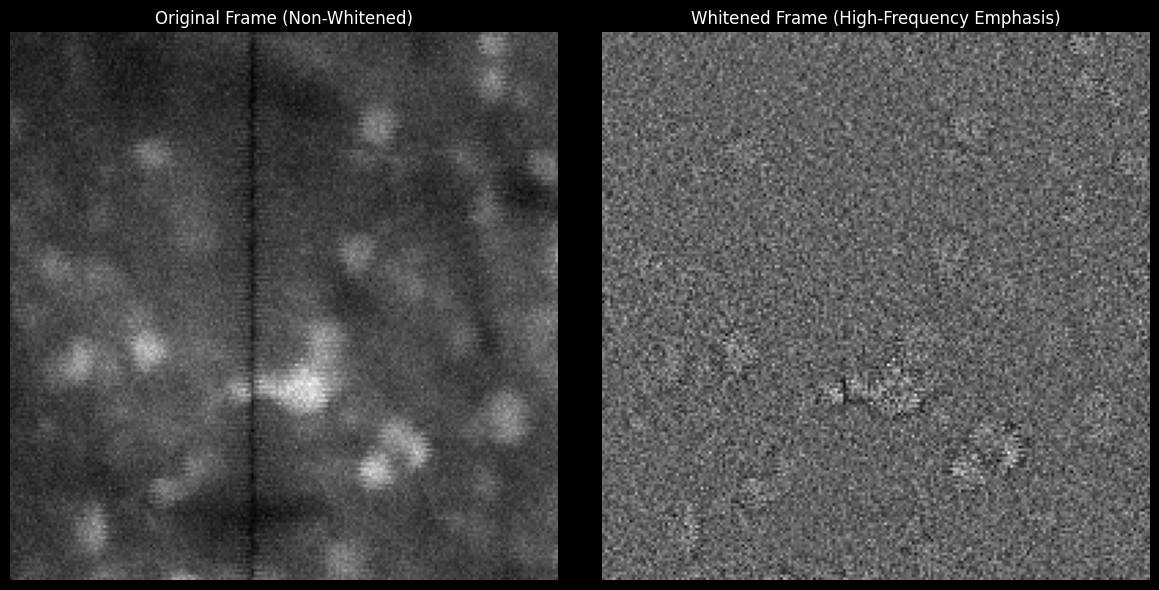

In [19]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2

i1 = 200
i2 = 400

# Load the Txy two-photon timeseries
img = tifffile.memmap("E:/datasets/high_resolution/zplanes/plane_1.tiff")  # Replace with your file path
T, Y, X = img.shape

# Select a single frame for demonstration
frame = img[500]  # First frame in the timeseries

# Spatial whitening function
def spatial_whitening(image):
    # Fourier transform of the image
    ft_image = fft2(image)
    # Normalize by magnitude (spatial whitening)
    ft_image_whitened = ft_image / (np.abs(ft_image) + 1e-8)
    # Inverse transform to return to spatial domain
    whitened_image = np.real(ifft2(ft_image_whitened))
    return whitened_image

# Apply spatial whitening
whitened_frame = spatial_whitening(frame)

# Plot original and whitened images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(frame[i1: i2, i1: i2], cmap="gray")
axes[0].set_title("Original Frame (Non-Whitened)")
axes[0].axis("off")

axes[1].imshow(whitened_frame[i1: i2, i1: i2], cmap="gray")
axes[1].set_title("Whitened Frame (High-Frequency Emphasis)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
